**DCGAN**

Сделано, исходя из этой статьи - https://arxiv.org/pdf/1511.06434v2.pdf

  Generative adversarial network(GAN) это 2 соревнующиеся между cобой модели - дискриминатор $D$ и генератор $G$. Они обучаются вместе, $D(x)$ принимает на вход картинку $x$ и возвращает вероятность, что это реальная картинка. $G(z)$ принимает $z$ - некоторый шум, и возвращает картинку. Мы будем подавать на вход дискриминатору, фейковую картинку, полученную от генератора - идеальный результат, если точность дискриминатора будет 50%, т.е он уже не отличает фейковую от реальной.

  Функция потерь для дискриминатора - это несколько видоизмененная бинарная кросс-энтропия: $log(D(x)) + log(1 - D(G(z)))$ - вот это пытаемся максимизировать (ставим знак минус для выражения и уже минимизируем). Сначала обучим $D$ на батче реальных картинок, с метками 1, тем самым занулим второе слагаемое в BCE, сделаем градиентный спуск, и так как в pytorch градиент накапливается, используем это. Пока, что не делаем step, делаем еще раз проход $D$ на картинках от $G$ с метками ноль, затем считаем градиенты. И вот теперь делаем optimizer.step()

  Функция потерь для генератора - $log(D(G(z)))$ - хотим максимизировать(со знаком минус минимизировать) вероятность того, что дискриминатор примет наш фейк за реальную картинку
  

Генератор в DCGAN имеет следующую архитектуру:

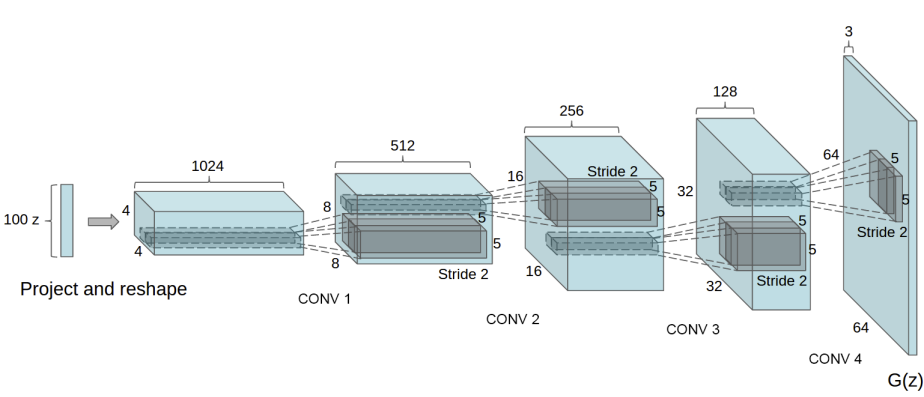

Ссылка на веса:  https://drive.google.com/uc?id=1Y_k9MdkDG3XV4tanSTWtRHJ3I6K6NG-z


In [2]:
#Ниже, скачивание файла с весами с гугл-диска в ноутбук
!gdown --id 1Y_k9MdkDG3XV4tanSTWtRHJ3I6K6NG-z

Downloading...
From: https://drive.google.com/uc?id=1Y_k9MdkDG3XV4tanSTWtRHJ3I6K6NG-z
To: /content/pok.pt
14.3MB [00:00, 54.1MB/s]


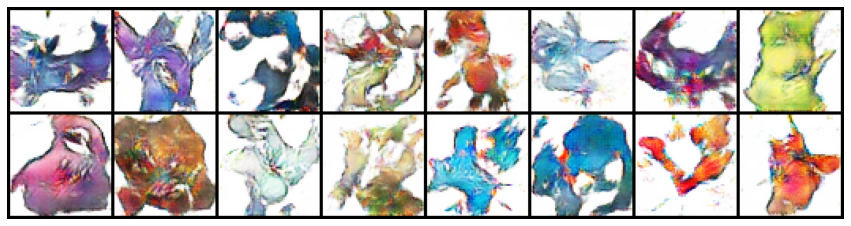

In [3]:
#эта ячейка выведет сгенерированные картинки
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
nc = 3
ngf = 64
b_size = 128
nz = 100
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

model = Generator(0)
model.load_state_dict(torch.load('pok.pt', map_location=torch.device('cpu')))


noise = torch.randn(16, nz, 1, 1, device=device)
        # Generate fake image batch with G
fake = model(noise)
#plt.imshow(np.transpose(vutils.make_grid(fake[0].data.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
img_list = []
fake = model(noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

fig = plt.figure(figsize=(15,15))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_list]

**Само обучение происходило в kaggle ноутбуке из-за доступа к их gpu и быстрой загрузке датасета**

**kaggle ноутбук: https://www.kaggle.com/romanfilonov/vk-pokemon**

GAN'ы очень чувствительны к настройке гиперпараметров, архитектура вся как в статье DCGAN:

1) У дискриминатора фнукция активация везде LeakyRelu

2) У генератора везде Relu, и только на последнем слое маштабирование в [-1,1] через Tanh

3) В обоих используем батчнорм

4) Инциализация весов обоих из $N(0, 0.02)$

5) Для обоих Adam c lr =  0.0002 и betta1 = 0.5 

Пробовал менять число эпох

num_epochs < 100 - картинка очень мыльная

100 < num_epochs < 200 - уже более менее

И num_epochs = 1000, 3 часа обучалась, примерно с 700-й эпохи D(x) = 1.0 и не менялось

Вот результат, после 1000 эпох: 

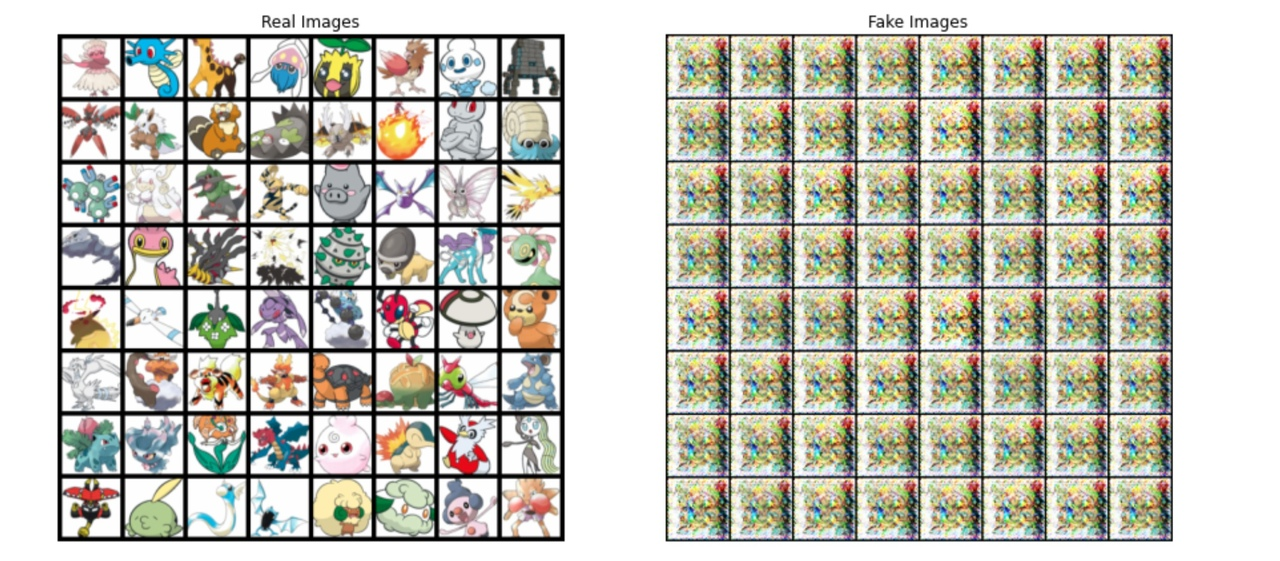